<a href="https://colab.research.google.com/github/tommylouistaylor/CEGE0004_MachineLearning/blob/master/3%20-%20Week/instance-based_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instance Based Learning
1. Implement k-Nearest Neighbors (kNN) algorithm in Python
2. Use kNN and SVN algorithms in scikit-learn.

## Prepare Wine Dataset

### The Wine Dataset

Each example from the [Wine dataset](https://archive.ics.uci.edu/ml/datasets/Wine) dataset contains:
* 13 attributes (xs) ~ containing quantities of each constituent
* 1 class identifier (ys) ~ containing id of the wine type

Properties:

|Property|Value|
|--|--|
|Classes|3|
|Samples per class|~59|
|Samples total|178|
|Dimensionality|13|
|Features|positive, natural and real|

### Read dataset

In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf) # print full array
%load_ext google.colab.data_table     # print full df

# reference data source
dataset_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'

# set col names manually, as no headers.
names = ['class', # label
         'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total phenols', 'flavanoids',
         'non-flavanoid phenols', 'proanthocyanins', 'color_intensity', 'hue', 'protein_content', 'proline']  # set col names manually, as no header.

# read dataset into df
df = pd.read_csv(dataset_url, names=names)

In [ ]:
# view df
df.head()

In [ ]:
# view summary statitics:
df.describe()

### Preprocessing: Split into Training and Test sets

In [ ]:
# randomise first to select unbiased set of examples
df = df.sample(frac=1)
df.head() # view randomised df

In [ ]:
# seperate output target class (ys) from the input feature attributes (xs)
import numpy as np
np.set_printoptions(suppress=True)          # print numbers with float precision
ys, xs = np.split(df.values, [1], axis=1)   # split feature array from target array
ys = ys.reshape(-1)                         # *** what does reshaping do here? ***

In [ ]:
# Partition 80% for training and 20% for testing
n_train = len(xs) * 80 // 100                         # get count for 80% of the datasets ~ 80% is 142 rows
xs_train, xs_test = np.split(xs, [n_train], axis=0)   # xs: 80% into train, remaining 20% into test
ys_train, ys_test = np.split(ys, [n_train], axis=0)   # ys: 80% into train, remaining 20% into test

In [ ]:
# print shape oto ensure split successful (rows, cols)
print('feature training set:\t', xs_train.shape)
print('feature test set:\t', xs_test.shape)
print('target training set:\t', ys_train.shape)
print('target test set:\t', ys_test.shape)

### Normalise Variation in Feature values (xs) to remove Bias

In [31]:
# Some attributes (xs) have a wider range (variance) than others
# attributes with lesser variance will dominate the Learner's distance function
# mitigate bias by deploying normalisation e.g. standardisation (aka z-score)

# get normalisation 'hyperparameters' from feature training set ~ value used to control the learning process
mu = np.mean(xs_train, axis=0)      # mean
sigma = np.std(xs_train, axis=0)    # sd

# create normalised version of feature training set using hyperparameters
xs_train = (xs_train - mu)/sigma    # creates normalised version of feature training set
xs_test = (xs_test - mu)/sigma      # apply same to feature test set

In [34]:
# test normalisation on training set
np.mean(xs_train, axis=0) # vector representing mean per col should show ONLY zero vals

array([ 0., -0.,  0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0., -0., -0.])

In [35]:
# test normalisation on test set
np.mean(xs_test, axis=0)  # vector representing mean per col should show CLOSE to zero vals

array([-0.1806259 , -0.04846662,  0.15877923,  0.29400117, -0.13000536,
       -0.17718004, -0.18778424,  0.12808511,  0.05581863,  0.1255761 ,
       -0.03218211, -0.13138969, -0.18586769])

## Implement Nearest Neighbor (NN) Algorithm in Python

In [ ]:
class NN: # implement NN from scratch

    def __init__(self, distance):
        self.training_examples = []
        self.distance = distance

    def add_example(self, x, y):
        """
        Add one example to the list of training examples.
        :param x: The vector of feature values
        :param y: The label associated to this example
        """
        self.training_examples.append((x, y))

    def add_examples(self, xs, ys):
        """
        Add a list of examples to the list of training examples.
        :param xs: A list of vectors of fature values
        :param ys: A list of labels associated to the examples
        """
        for x, y in zip(xs, ys):
            self.add_example(x, y)

    def closest_training_example(self, x_q):
        y_closest = None
        x_closest = None
        min_score = float('inf')
        # find closest example
        for x, y in self.training_examples:
            score = self.distance(x_q, x)
            if score < min_score:
                min_score = score
                x_closest = x
                y_closest = y

        return x_closest, y_closest

    def classify(self, xq):
        _, y_hat = self.closest_training_example(xq)
        return y_hat

In order to instantiate this classifier we need to define a distance function. Since we are dealing with continuous
features we will define the euclidean distance. You are invited to develop and test another distance measure.

In [ ]:
def euclidean_distance(x_1, x_2):
    res = 0
    for a_1, a_2 in zip(x_1, x_2):
        res += (a_1 - a_2) ** 2
    res **= 0.5
    return res

The euclidean distance of the points (0, 0) and (1, 1) should be $\sqrt{2}$.

In [ ]:
euclidean_distance([0, 0], [1, 1])

<function __main__.euclidean_distance>

We now instantiate the NN classifier and train it.

In [ ]:
nn_clf = NN(euclidean_distance)         # make instance of NN class called nn_clf

nn_clf.add_examples(xs_train, ys_train) # add feature and target training datasets to NN class method

To evaluate how this classifier performs on the test set we will measure its accuracy. Note that evaluating the
accuracy on the training set is pointless because this will always be 1 by definition. We will now do also this only for
instructive purposes.

We now define the accuracy measure. Remember that the accuracy is equal to the proportion of examples that the
classifier predicted correctly.

In [ ]:
def accuracy(ys, ys_hat):
    res = 0
    for y, y_hat in zip(ys, ys_hat):
        if y == y_hat:
            res += 1
    res /= len(ys)
    return res

We now test the classifier on both training and test sets.

In [ ]:
ys_train_pred = []
for x in xs_train:
    y_hat = nn_clf.classify(x)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = nn_clf.classify(x)
    ys_test_pred.append(y_hat)

print('Train accuracy of NN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of NN', accuracy(ys_test, ys_test_pred))

Train accuracy of NN 1.0
Test accuracy of NN 1.0


Let's now compare the test result of this classifier to a random classifier. Is this NN classifier any better?
Remember that a random classifier would correctly predict the class one third of the times.

In [ ]:
ys_test_pred_random = np.random.randint(1, 4, len(ys_test))                             # create random cluster
print('Test accuracy of a random classifier', accuracy(ys_test, ys_test_pred_random))   # test accuracy against a random 

Test accuracy of a random classifier 0.3333333333333333


Let's have a look at the result of a random classifier by repeating this experiment many times.

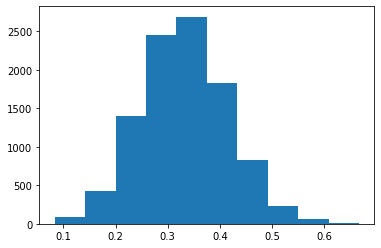

Expected accuracy of a random classifier 0.33392777777777777


In [ ]:
from matplotlib import pyplot as plt

accuracies = []
for _ in range(10000):
    ys_test_pred_random = np.random.randint(1, 4, len(ys_test))
    accuracies.append(accuracy(ys_test, ys_test_pred_random))

plt.hist(accuracies)
plt.show()

print('Expected accuracy of a random classifier', np.mean(accuracies))

Does this accuracy make sense? Is this accuracy similar to the one you had predicted?

## Implement k-Nearest Neighbor (kNN) Algorithm in Python (extented from NN)

We will now extend the NN algorithm to develop the k-Nearest Neighbor (kNN) algorithm.
By extending the NN algorithm we avoid repeating the training code. This is in fact the same.
In the classification method, in order to avoid the sorting of
all the examples after having measured their score, we will make use of priority queues, which allow us to keep track
only of the first $k$-nearest examples, making the code more efficient. You are free to implement the version where
first all the examples are scored, then sorted and selected. These two versions, if correctly implemented,
should produce to the same result.

In [ ]:
from statistics import mode
from heapq import heappush, heappushpop

class KNN(NN):

    def __init__(self, distance):
        super().__init__(distance)

    def closest_training_examples(self, x_q, k=1):
        k_nearest = []

        # initialize an heap with k elements
        for x, y  in self.training_examples[:k]:
            score = self.distance(x_q, x)
            heappush(k_nearest, (-score, (x, y)))

        # find the k-nearest example
        for x, y in self.training_examples[k:]:
            score = self.distance(x_q, x)
            heappushpop(k_nearest, (-score, (x, y)))

        # we no longer need to keep the score
        res = [(x, y) for _, (x, y) in k_nearest]
        return res

    def classify(self, x_q, k = 1):
        # find the k closest
        k_nearest_xs, k_nearest_ys = zip(*self.closest_training_examples(x_q, k))
        # return the mode
        return mode(k_nearest_ys)

We now train and test this algorithm in the same way we did for the NN algorithm.

In [ ]:
knn_clf = KNN(euclidean_distance)

knn_clf.add_examples(xs_train, ys_train)

ys_train_pred = []
for x in xs_train:
    y_hat = knn_clf.classify(x)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = knn_clf.classify(x)
    ys_test_pred.append(y_hat)

print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

Train accuracy of kNN 1.0
Test accuracy of kNN 1.0


Nothing has changed with respect to the NN algorithm because we have implicitly used $k=1$. Let's now try $k=5$.

In [ ]:
ys_train_pred = []
for x in xs_train:
    y_hat = knn_clf.classify(x, 5)
    ys_train_pred.append(y_hat)

ys_test_pred = []
for x in xs_test:
    y_hat = knn_clf.classify(x, 5)
    ys_test_pred.append(y_hat)


print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

Train accuracy of kNN 0.9647887323943662
Test accuracy of kNN 0.9722222222222222


It seems that considering more points did not help. Note that this time the training accuracy has changed. Can you
explain why?

## Implement k-Nearest Neighbor (kNN) Algorithm in Scikit-Learn using SPECIFIC Hyper-Paramaters

In [37]:
# call the classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean') # pass n_neighbors and metric 'hyper-parameters'

In [ ]:
# train the classifier with training datasets
knn_clf.fit(xs_train, ys_train)

In [ ]:
# predict class (ys~wine type) using classifier
ys_test_pred = knn_clf.predict(xs_test)
ys_test_pred

In [ ]:
# evaluate the result of classifier by performing an accuracy test
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(ys_test, ys_test_pred)  # compare predicted classes against true classes
print('Test accuracy of kNN', accuracy)           # 1=accuracy, 0=not accurate

## Implement k-Nearest Neighbor (kNN) Algorithm in Scikit-Learn using OPTIMUM Hyper-Paramaters
Overtuning the hyper-parameters (e.g. n-neighbors, metric) when training the classifier can lead to overfitting on the test set ~ aka classifier learns the 'noise' of the training set too well and becomes less effective when applied to the test set. Using k-fold cross-validation to find the optimum hyper-paramaters will ensure the accuracy measured on the test set is representitive of what is expected on unseen examples.

In [ ]:
# firstly confirm that retuning the hyper-parameters will change the outcome
knn_clf = KNeighborsClassifier(n_neighbors=1, metric='cosine')        # call classifier and specify cosine metric
knn_clf.fit(xs_train, ys_train)                                       # train classifier with dataset
ys_test_pred = knn_clf.predict(xs_test)                               # predict the classes using the trained classifer
print('Test accuracy of kNN', accuracy_score(ys_test, ys_test_pred))  # test accuracy of result

In [ ]:
# specify a set of hyperparameters to explore
param_grid = [{
  'weights': ["uniform", "distance"],
  'n_neighbors': range(1, 11),
  'metric':['euclidean', 'manhattan', 'cosine']}]

# find best combination of hyperparameters using K-fold cross-validation
from sklearn.model_selection import GridSearchCV
knn_clf = KNeighborsClassifier()                                      # call kNN classifier WITHOUT specifying params
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=2)      # loop through ALL predefined params using GridSearchCV
grid_search.fit(xs_train, ys_train)                                   # fit ALL learners onto the training set

In [81]:
# best hyper-parameters found by cross-validation
best_estimator = grid_search.best_estimator_
best_estimator

KNeighborsClassifier(metric='manhattan', n_neighbors=3)

In [111]:
# call classifier using optimum hyper-parameters
knn_clf = best_estimator

# train classifier with training set
knn_clf.fit(xs_train, ys_train)           

# predict class using classifier
ys_train_pred_ = knn_clf.predict(xs_train)
ys_test_pred_ = knn_clf.predict(xs_test)

# evaluate result accuracy
accuracy(ys_test, ys_test_pred)
#print('Train accuracy of kNN', accuracy(ys_train, ys_train_pred))
#print('Test accuracy of kNN', accuracy(ys_test, ys_test_pred))

TypeError: ignored

## Implement Support Vector Machines (SVM) in Scikit-Learn using SPECIFIC hyper-parameters

Note how we are setting the $C$ hyper-parameter of SVM. $C$ controls the trade-off between having a small and strict
margin and a wider and loose margin. Following we will set $C$ to infinity which makes the margin infinitely strict.
This means that based on the dataset, the fitting of the SVM may fail if the training algorithm fails to separate all
the training examples perfectly.

In [90]:
# call classifier and set hyper-parameters
from sklearn.svm import SVC
svm_clf = SVC(kernel="linear", C=float("inf")) # C controls trade-off between small-strict margin and wide-loose margin

In [ ]:
# train classifier using training set
svm_clf.fit(xs_train, ys_train) # SVM training algorithm fits the training examples

In [94]:
# predict class using classifier
ys_train_pred = svm_clf.predict(xs_train)
ys_test_pred = svm_clf.predict(xs_test)

In [95]:
# evaluate result
print('Train accuracy of SVM', accuracy(ys_train, ys_train_pred))
print('Test accuracy of SVM', accuracy(ys_test, ys_test_pred))

TypeError: ignored

How would you find the best hyper-parameter C value? Try re-implement the code used to validate the kNN
classifier above.